[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Aggregation of PECD regions (v4.2 and v4.2_v2) into NUTS0 polygons

This notebook provides an overview of how to download one of the available energy indicators from the Pan-European Climate Database version 4.2 ([PECDv4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview)) or future PECDv4.2_v2: the onshore wind generation (WON) data at the PEON (PECD onshore regions) level, and how to aggregate it to NUTS0 polygons using pre-specified weights. Aggregating wind generation to any set of polygons requires a weighted approach, where the weights correspond to the relative installed capacities of the regions as it will be explained. The analysis focuses on the existing onshore wind generation fleet, considering one year of data (2020) from the historical stream (1950–present).
In principle, this workflow can be extended to include multiple years, climate projection periods (2015–2100), and other wind technologies.

The following data are used in the notebook:

1. Pre-calculted [weights](https://gitlab.windenergy.dtu.dk/corres/corres/-/tree/c3s_PECD4.2/c3s_PECD_4.2_runs/inputs_general/Aggregation_weights?ref_type=heads); here we present an example based on the weights associated with existing onshore wind technologies (i.e., the 2020 wind fleet).
These weights are read from the file PECD4.2/Onshore_Existing_run.xlsx, which has been converted to CSV format and provided together with this notebook.
If we were working with future onshore technologies, the corresponding weights would instead come from PECD4.2/Onshore_Future_tech_runs.xlsx (also converted to CSV and included with this notebook).
Similarly, for PECD4.2_v2 data, the relevant weight files from that version’s folder should be used — they, too, are distributed alongside this notebook.
2. PECD version 4.2 data for the Historical temporal stream (based on ERA5 reanalysis). The selected variable is Wind power onshore capacity factor, with Tech type 30 representing existing wind technologies (i.e. the 2020 wind fleet) and Resource Grade B energy scenario. These data will be downloaded within this notebook.
3. Shapefiles of NUTS0 and PECDv4.2 polygons (originally provided by ENTSO-E), used for spatial reference and visualization, also distrivuted alongside this notebook.

## Learning objectives 🧠

In this notebook, you will learn on **how to generate NUTS0 data using PECD data and pre-calculated weights**.  In addition, you will learn how to quickly download and read the PECDv4.2 CSV files as well as plotting polygon maps from a given shapefile.

## Target Audience 🎯

**Anyone** interested in spatial aggregation of wind generation timeseries from PECD to NUTS0 using CSV data and region-based weighting.

## Prepare your environment

### Import libraries

In the following, we will import four libraries: the [os](https://docs.python.org/3/library/os.html) module provides functions to interact with the operating system, particularly for handling files, directories, and environment variables. It enables the script to build portable paths and manage local data resources efficiently. The [pathlib](https://docs.python.org/3/library/pathlib.html) module offers an object-oriented interface for working with filesystem paths, making file handling more readable and robust. The [pandas](https://pandas.pydata.org/docs/) library is used to load, manipulate, and analyze tabular datasets, providing high-level data structures and operations. The [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) module is used to create and customize a wide range of visualizations, while [geopandas](https://geopandas.org/en/stable/) provides powerful tools for managing and displaying spatial data. The [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) package enables direct access to the Copernicus Climate Data Store (CDS), making it possible to retrieve the datasets required for this analysis programmatically. The [cartopy](https://cartopy.readthedocs.io/stable/) supports a wide range of map projections, coastlines, and grid features, enabling the creation of detailed and customizable geographic visualizations for scientific and analytical purposes. Finally, [numpy](https://numpy.org/doc/stable) supports efficient numerical computations and is often used for creating and handling arrays or sequences of numerical values.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy
import cdsapi

### Set up the CDS API and your credentials

This step is essential to be able to download the data. For a complete walkthrough of downloading data from the Climate Data Store (CDS) via the CDS API, see the notebook [*Downloading PECDv4.2 data from the CDS via cdsapi*](./download-data-from-cds.ipynb).

If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes ```"your_api_key"```). Your token can be found on the [CDS portal](https://cds.climate.copernicus.eu/profile) (you will need to log in to see your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [ ]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

In this example, we utilize data from the PECD dataset version 'PECD4.2' for the 'Historical' temporal stream, which is based on 'ERA5 reanalysis' data. The variable selected is the 'Wind power onshore capacity factor', the technology type 30: Existing wind technologies (i.e., 2020 wind fleet) and, for energy scenario, the "Resource Grade B" is considered.

The API request reflecting these selections is shown in the next cell.

In [ ]:
# define our dataset
dataset = "sis-energy-pecd"

# dictionary of base request
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "variable": ["wind_power_onshore_capacity_factor"],
    "technology": ["30"],
    "energy_scenario": ["resource_grade_b"],
    "spatial_resolution": ["peon"],
    "year": ["2020"],
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

## Create folders with data
Next, we will create a dedicated folders to store our data (weights and timeseries). 
In particular, in this step, we’ll download the selected PECD dataset directly from the Copernicus Climate Data Store (CDS) using the cdsapi client.
The cell below will:
- Create a local folder called timeseries/ to store the downloaded files.
- Initialize the CDS API client using your authentication key and URL.
- Retrieve the requested dataset (as defined by dataset and request) and save it as a ZIP file inside the input directory.
- Unzip the downloaded files so they can be accessed and used in the following analysis steps.
This ensures all required input data are correctly downloaded and ready to be processed within the notebook.

In [ ]:
# create folder for cds data
input_dir = "./timeseries/"
os.system(f"mkdir -p {input_dir}")

# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/won_cf_data.zip")

# Unzipping every file in our folder
for fname in os.listdir(input_dir):
    if fname.endswith(".zip"):
        os.system(f"unzip {input_dir}/{fname} -d {input_dir}")


## Visualize Polygons

Visualization of spatial data with GeoPandas and Cartopy helps in mapping and verifying the regional aggregation. For this reason, before aggregating or analyzing the data, it is helpful to visually inspect the NUTS0 boundaries (country-level polygons) used in the PECD dataset. 
This ensures the shapefile is loaded correctly and that the codes used for spatial joins or aggregations (e.g., PECD_CODE) correspond to the expected geographic regions.
In the cell below:
- We read the shapefile containing NUTS0 polygons.
- We plot these polygons using cartopy for geographic projection and geopandas for vector visualization.
- Each region is labeled with its PECD code, allowing quick verification of geometry and identifiers.

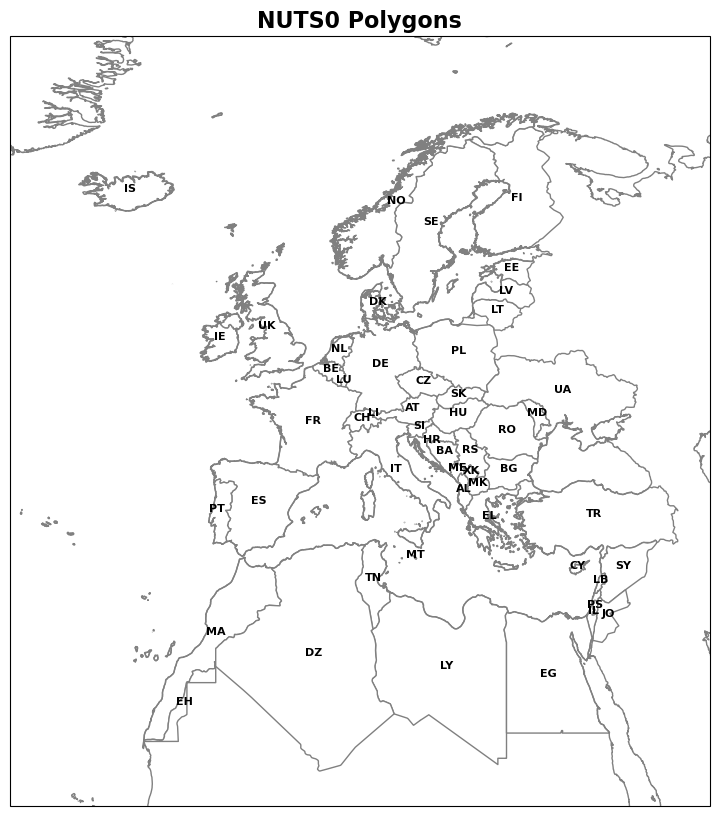

In [6]:
# Visualize NUTS0
#read shapefile
shp=gpd.read_file("zip://./shapefiles/NUT0_ADM0_PECD.zip!NUT0_ADM0_PECD/NUT0_ADM0_PECDCODE.shp")
# Reproject to a suitable projected CRS (Europe example)
shp_proj = shp.to_crs(epsg=3035)  # ETRS89 / LAEA Europe

# make plot
fig = plt.figure(figsize=[10, 10])
map_proj = cartopy.crs.PlateCarree()
ax = plt.axes(projection=map_proj)
ax.coastlines(resolution="10m", color="grey")

shp.plot(color="white", edgecolors="grey", linewidths=1, ax=ax)

# Annotate with projected centroids transformed back to lon/lat
for i, row in shp_proj.iterrows():
    centroid = row.geometry.centroid
    # transform centroid back to original CRS for plotting
    centroid_lonlat = gpd.GeoSeries([centroid], crs=shp_proj.crs).to_crs(shp.crs)
    x, y = centroid_lonlat.geometry.iloc[0].coords[0]
    ax.text(x, y, row["PECD_CODE"], ha="center", fontsize=8, color="black", weight="bold")

ax.set_title("NUTS0 Polygons", fontsize=16, fontweight="bold")
plt.show()


The figure above confirms that:
- Each NUTS0 region is properly represented by its geometry and labeled with its PECD code.
- The coastlines provide geographic context, making it easy to validate boundaries against familiar shapes.

Before working with the PECD version 4.2 dataset, it’s useful to take a quick look at the onshore regions included in the shapefile.
In this step, we’ll:
- Read the PECD v4.2 shapefile containing all regions (both onshore and offshore).
- Filter out offshore areas to keep only the onshore polygons.
- Plot the resulting regions on a map using a simple cartographic projection.
- Label each region with its corresponding code for easy identification.
This quick visualization helps confirm that the shapefile is loaded correctly, the filtering step works as expected, and the geographic regions align with our analysis needs.

Text(0.5, 1.0, 'PECD v4.2 Onshore Polygons')

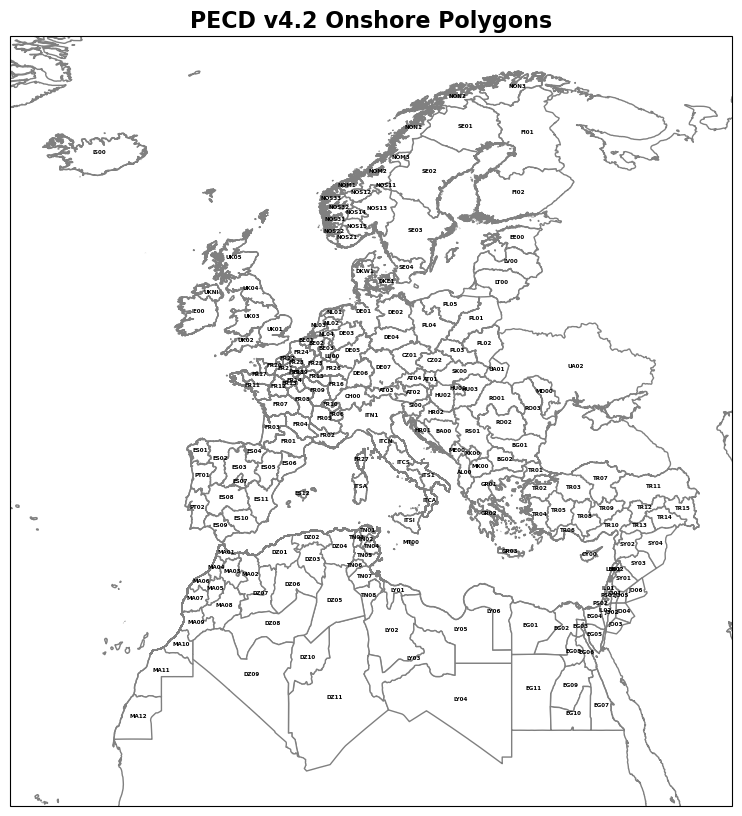

In [9]:
# Visualize PECD v4.2 Onshore Regsions
#read shapefile
shp = gpd.read_file("zip://./shapefiles/PECD42_v2_final.zip!PECD42_v2_final/PECD42_v2_final.shp")
# keep only onshore regions
shp = shp[~shp['Code'].str.contains('_OFF')]

# Use a projected CRS appropriate for Europe (example: ETRS89 / LAEA Europe)
shp_proj = shp.to_crs(epsg=3035)  # Replace EPSG if your data is from another region

# make plot
fig = plt.figure(figsize=[10, 10])
map_proj = cartopy.crs.PlateCarree()
ax = plt.axes(projection=map_proj)
ax.coastlines(resolution="10m", color="grey")

shp.plot(color="white", edgecolors="grey", linewidths=1, ax=ax)

# --- Annotate using projected centroids ---
for i, row in shp_proj.iterrows():
    centroid = row.geometry.centroid
    # Convert centroid back to geographic coordinates (for plotting)
    centroid_geo = gpd.GeoSeries([centroid], crs=shp_proj.crs).to_crs(shp.crs)
    x, y = centroid_geo.geometry.iloc[0].coords[0]
    
    ax.text(
        x, y, row["Code"],
        ha="center",
        fontsize=4,
        color="black",
        weight="bold"
    )

ax.set_title("PECD v4.2 Onshore Polygons", fontsize=16, fontweight="bold")


The figure above shows all onshore PECD v4.2 regions, each outlined in black and labeled with its corresponding regional code.
This quick check confirms that the shapefile has been read and filtered correctly — only onshore polygons are displayed, while offshore areas (codes containing _OFF) have been excluded.
The map provides a clear spatial reference for the next steps of the analysis, ensuring that the regional structure of the dataset is correctly interpreted before moving on to data aggregation and weighting.

### Create output folder where the final aggregated data will be saved

In [34]:
# Create output folder that will hold aggregated results
output_folder = "./output/"
Path(output_folder).mkdir(parents=True, exist_ok=True)

### Reading the pre-calculated weights

In this example, we are aggregating existing wind technologies (i.e., the 2020 wind fleet), so the weights are read from PECD4.2/Onshore_Existing_run.csv. If we were working with a future onshore technology, the weights would instead be taken from Onshore_Future_tech_runs.csv.

In [10]:
# Define path to pre-calculated weights file
weight_file_pth = "weights/PECD4.2/Onshore_Existing_run.csv"

# read in pre-calculated weights
reginfo = pd.read_csv(weight_file_pth)
print(reginfo)

    PECD_CODE PECD_STUDY_ZONE Country NUTS0  Weight_in_aggregation  \
0        AT01            AT00      AT    AT                  4.600   
1        AT02            AT00      AT    AT                294.120   
2        AT03            AT00      AT    AT               2792.407   
3        BA00            BA00      BA    BA                 86.600   
4        BE01            BE00      BE    BE                582.710   
..        ...             ...     ...   ...                    ...   
125      UK03            UK00      UK    UK               2068.215   
126      UK04            UK00      UK    UK               4854.805   
127      UK05            UK00      UK    UK               4537.860   
128      UKNI            UKNI      UK    UK               1217.885   
129      XK00            RS00      XK    XK                 32.400   

     Installed_capacity_MW  
0                    4.600  
1                  294.120  
2                 2792.407  
3                   86.600  
4             

### Building Dictionaries for Regional and Country-Level Weights

Using Python dictionaries to store region- and country-level weights allows for quick access and flexible aggregation of time series data.
In this step, we’ll create a few dictionaries that summarize the wind capacity weights at both the country and regional levels. These dictionaries will later be used in the aggregation step to combine regional capacity factor timeseries into country-level averages.
A dictionary in Python is a data structure that stores information as key–value pairs — similar to a small, in-memory database. It allows us to quickly retrieve a value (like a number or a list) when we know its key (for example, a country or region code).
Here, we’ll build three dictionaries, each serving a specific purpose:
- country_region_dict
Links each country (NUTS0 code) to the list of PECD regions that belong to it and have non-zero weights.
→ Useful for identifying which regions contribute to each country’s aggregation.
- capacity_country_dict
Stores, for each country, the sum of all aggregation weights from its associated regions.
→ This represents the country’s total “capacity weight” in the analysis.
- capacity_region_dict
Stores the individual weight of each PECD region.
→ Enables quick access to a specific region’s capacity contribution.
Together, these dictionaries act as a simple but powerful mapping system — making it easy to move between country-level and region-level information and to apply the correct weights in subsequent calculations.


In [11]:

capacity_country_dict = dict()
country_region_dict = dict()

for iter1 in reginfo["NUTS0"].unique():
    mask = (reginfo["NUTS0"] == iter1) & (reginfo["Weight_in_aggregation"] > 0)
    country_region_dict[iter1] = list(reginfo["PECD_CODE"].loc[mask])
    capacity_country_dict[iter1] = sum(reginfo["Weight_in_aggregation"].loc[mask])

capacity_region_dict = dict()
for iter1 in reginfo["PECD_CODE"]:
    mask = reginfo["PECD_CODE"] == iter1
    capacity_region_dict[iter1] = reginfo["Weight_in_aggregation"].loc[mask].values[0]

    
print(capacity_region_dict)




{'AT01': np.float64(4.6), 'AT02': np.float64(294.12), 'AT03': np.float64(2792.407), 'BA00': np.float64(86.6), 'BE01': np.float64(582.71), 'BE02': np.float64(1117.96), 'BE03': np.float64(818.53), 'BG01': np.float64(690.6), 'BG02': np.float64(21.0), 'CH00': np.float64(86.8), 'CY00': np.float64(164.75), 'CZ01': np.float64(226.39), 'CZ02': np.float64(113.67), 'DE01': np.float64(18439.705), 'DE02': np.float64(11548.175), 'DE03': np.float64(5815.227), 'DE04': np.float64(7238.132), 'DE05': np.float64(6444.755), 'DE06': np.float64(1545.362), 'DE07': np.float64(2571.765), 'DKE1': np.float64(679.249), 'DKW1': np.float64(3193.755), 'DZ02': np.float64(10.2), 'EE00': np.float64(383.21), 'EG00': np.float64(1227.47), 'ES01': np.float64(3717.65), 'ES02': np.float64(1773.79), 'ES03': np.float64(5355.905), 'ES04': np.float64(1839.34), 'ES05': np.float64(2764.85), 'ES06': np.float64(1069.05), 'ES08': np.float64(366.2), 'ES09': np.float64(1996.92), 'ES10': np.float64(793.73), 'ES11': np.float64(4401.87), 

### Loading the Timeseries Data
CSV-based energy data can be easily loaded, explored, and summarized using pandas, allowing for efficient analysis and manipulation.
Indeed, in the next step, we will read the already downloaded CSV timeseries data and prepare it for applying the aggregation weights.
The CSV file specified below contains hourly capacity factor values for onshore wind power. Each row corresponds to a specific timestamp, while the columns represent different regions or grid cells used in the PECD framework.
In this cell, we:
- Define the path to the input CSV file (ts_fn),
- Use pandas.read_csv() to load the data into a DataFrame,
- Set the "Date" column as the index, so time becomes the main reference axis,
- Display the resulting dataset to confirm it has been read correctly.
This timeseries will serve as the base data to which we’ll apply the aggregation weights in the next step, allowing us to compute country-level capacity factor time series from the regional values.

In [13]:
# Load CorRES results
ts_fn="timeseries/H_ERA5_ECMW_T639_WON_NA---_Pecd_PEON_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_30_NA---_ReGrB_PhM04_PECD4.2_fv1.csv"
ts = pd.read_csv(ts_fn, comment="#",index_col="Date")
print(ts)


    

                     AL00    AT01    AT02    AT03    BA00    BE01    BE02  \
Date                                                                        
2020-01-01 00:00:00   NaN  0.2054  0.2034  0.5046  0.8917  0.2019  0.1801   
2020-01-01 01:00:00   NaN  0.0589  0.1634  0.4887  0.8903  0.1931  0.1553   
2020-01-01 02:00:00   NaN  0.0434  0.1337  0.4674  0.8951  0.1960  0.1843   
2020-01-01 03:00:00   NaN  0.0393  0.1062  0.4338  0.8971  0.1930  0.2138   
2020-01-01 04:00:00   NaN  0.0278  0.0963  0.4528  0.8988  0.1811  0.2247   
...                   ...     ...     ...     ...     ...     ...     ...   
2020-12-31 19:00:00   NaN  0.0954  0.1545  0.0061  0.0060  0.0158  0.0112   
2020-12-31 20:00:00   NaN  0.0812  0.1442  0.0107  0.0098  0.0130  0.0101   
2020-12-31 21:00:00   NaN  0.0943  0.1465  0.0207  0.0487  0.0100  0.0105   
2020-12-31 22:00:00   NaN  0.0962  0.1242  0.0238  0.0472  0.0145  0.0168   
2020-12-31 23:00:00   NaN  0.2090  0.1479  0.0216  0.0387  0.0061  0.0157   

### Applying Aggregation Weights to the Timeseries
Now that both the regional timeseries (ts) and the aggregation weights (capacity_region_dict) are available, we can combine them to compute weighted regional contributions.
In this step, each column in the timeseries (representing a PECD region) is multiplied by its corresponding weight from capacity_region_dict.
This operation scales the hourly capacity factor values by the relative importance (or installed capacity share) of each region in the overall aggregation.
Technically, we use the pandas.DataFrame.multiply() method, aligning columns in the DataFrame with the keys of the weight dictionary. The result — stored in weighted_df — contains the weighted capacity factor timeseries for each region.
These weighted values will then be used to compute country-level averages in the next step of the workflow.

In [14]:
# Apply Weights
weighted_df = ts.multiply(pd.Series(capacity_region_dict), axis=1)
print(weighted_df.head())

                     AL00     AT01       AT02         AT03      BA00  \
Date                                                                   
2020-01-01 00:00:00   NaN  0.94484  59.824008  1409.048572  77.22122   
2020-01-01 01:00:00   NaN  0.27094  48.059208  1364.649301  77.09998   
2020-01-01 02:00:00   NaN  0.19964  39.323844  1305.171032  77.51566   
2020-01-01 03:00:00   NaN  0.18078  31.235544  1211.346157  77.68886   
2020-01-01 04:00:00   NaN  0.12788  28.323756  1264.401890  77.83608   

                           BE01        BE02        BE03       BG01    BG02  \
Date                                                                         
2020-01-01 00:00:00  117.649149  201.344596  123.434324  289.91388  0.6216   
2020-01-01 01:00:00  112.521301  173.619188  116.886084  250.68780  0.1365   
2020-01-01 02:00:00  114.211160  206.040028  132.601860  243.22932  0.0504   
2020-01-01 03:00:00  112.463030  239.019848  131.783330  250.34250  1.3482   
2020-01-01 04:00:00  105.52

### Aggregating Weighted Timeseries to the Country Level
With the weighted regional timeseries ready, the next step is to aggregate them to obtain a single, representative capacity factor timeseries for each country (NUTS0 region).
Here’s what happens in this cell:
- Sum weighted regional values:
For each country, we retrieve the list of regions that belong to it (from country_region_dict) and sum their weighted timeseries across all time steps.
→ This gives the total weighted capacity factor for the country at each hour.
- Create an aggregated DataFrame:
The results are collected into a new DataFrame called aggregated_df, where each column corresponds to a country and each row represents an hourly timestamp.
- Normalize by total capacity:
Finally, we divide each country’s summed values by its total capacity weight (from capacity_country_dict) to obtain normalized capacity factor timeseries — effectively the country-level average capacity factor.


The resulting aggregated_df contains one clean, continuous capacity factor timeseries per country, ready for analysis or visualization in the next steps.

In [15]:
# Aggregate 
aggregated_data = {}
for group, columns in country_region_dict.items():
    aggregated_data[group] = weighted_df[columns].sum(axis=1)

# Create the final aggregated DataFrame
aggregated_df = pd.DataFrame(aggregated_data)

# Normalize by total capacity per country or region
aggregated_df = aggregated_df.divide(pd.Series(capacity_country_dict), axis=1)

print(aggregated_df.head())

                           AT      BA        BE        BG      CH      CY  \
Date                                                                        
2020-01-01 00:00:00  0.475496  0.8917  0.175622  0.408285  0.1180  0.1865   
2020-01-01 01:00:00  0.457108  0.8903  0.159982  0.352479  0.0466  0.1812   
2020-01-01 02:00:00  0.435018  0.8951  0.179761  0.341877  0.0086  0.1672   
2020-01-01 03:00:00  0.402042  0.8971  0.191833  0.353697  0.0028  0.1397   
2020-01-01 04:00:00  0.418247  0.8988  0.195282  0.447285  0.0029  0.1133   

                           CZ        DE        DK      DZ  ...      RS  \
Date                                                       ...           
2020-01-01 00:00:00  0.160716  0.096269  0.259452  0.1875  ...  0.2922   
2020-01-01 01:00:00  0.120765  0.098218  0.308458  0.1606  ...  0.2664   
2020-01-01 02:00:00  0.118375  0.096948  0.338247  0.1413  ...  0.3057   
2020-01-01 03:00:00  0.109466  0.099790  0.356476  0.1164  ...  0.2228   
2020-01-01 04:00

In [42]:
# ## Save Results
file_name = os.path.basename(ts_fn)
output_file = Path(output_folder) / f"{file_name.split('.')[0]}_NUTS0_level.csv"
aggregated_df.to_csv(output_file)


## Take home messages 📌

* The code above illustrates how to convert onshore wind generation time series from PECD v4.2 into NUTS0-level polygons.

* Aggregating wind generation to any set of polygons requires a weighted approach, where the weights correspond to the relative installed capacities of the regions.

* CSV-based energy data can be easily loaded, explored, and summarized using pandas, allowing for efficient analysis and manipulation.

* Using dictionaries to store region- and country-level weights enables quick access and flexible aggregation of time series.

* Visualization of spatial data with GeoPandas and Cartopy helps in mapping and verifying the regional aggregation.

* This workflow can be extended to future wind technologies by simply change the weight file, making it adaptable to different scenarios.